# Import dataset csv

In [1]:
import pandas as pd
train_data = pd.read_csv(r'../data/train.csv')
test_data = pd.read_csv(r'../data/test.csv')

# Importar matrizes de conectividade

In [2]:
import numpy as np
import scipy.io

train_mat = scipy.io.loadmat('../data/train_data.mat') 
test_mat = scipy.io.loadmat('../data/test_data.mat') 

In [3]:
def get_data_from_mat(train_file,test_file):
    train_mat = scipy.io.loadmat(train_file) 
    test_mat = scipy.io.loadmat(test_file) 
    print(train_mat.keys())
    print(test_mat.keys())
    train_np = np.array(train_mat['train_data']).transpose(2,0,1)
    test_np = np.array(test_mat['test_data']).transpose(2,0,1)
    print(train_np.shape)
    print(test_np.shape)
    return  train_np, test_np


train_mat, test_mat = get_data_from_mat('../data/train_data.mat','../data/test_data.mat')

dict_keys(['__header__', '__version__', '__globals__', 'train_data'])
dict_keys(['__header__', '__version__', '__globals__', 'test_data'])
(112, 90, 90)
(28, 90, 90)


# Visualisar os dados

In [4]:
import numpy as np
import scipy.io

mat = scipy.io.loadmat('../data/train_data.mat')

X = mat["train_data"]
print(X)

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.13152513 0.11770353 0.15580596 ... 0.11608478 0.15665442 0.11458643]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.02631835 0.01242944 0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.01770987 0.         0.        ]]

 [[0.13152513 0.11770353 0.15580596 ... 0.11608478 0.15665442 0.11458643]
  [0.         0.      

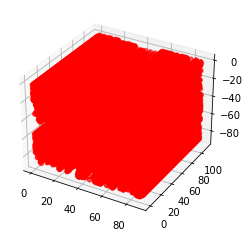

In [5]:
#todos
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

z,x,y = X.nonzero()
            
ax.scatter(x, y, -z, zdir='z', c= 'red')
plt.show()

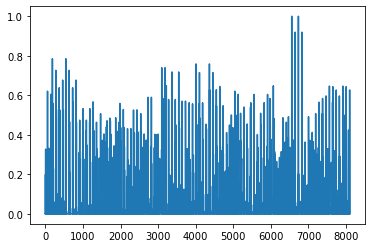

In [6]:
#Exemplo 1 pessoa
store = []
for i in range(90):
    for j in range (90):
        store.append(X[i][j][15])
        #print(X[i][j][0])
        
plt.plot(store)

# Tratar Dados

In [7]:
education_train = []
for ar in zip(train_data['education']):
    age = ar[0]
    if age > 16:
        education_train.append('Muito Alta')
    elif age > 12: 
        education_train.append('Alta')
    elif age > 8: 
        education_train.append('Normal')
    elif age > 4:
        education_train.append('Baixa')
    else:
        education_train.append('Muito Baixa')

education_test = []
for ar in zip(test_data['education']):
    age = ar[0]
    if age > 16:
        education_test.append('Muito Alta')
    elif age > 12: 
        education_test.append('Alta')
    elif age > 8: 
        education_test.append('Normal')
    elif age > 4:
        education_test.append('Baixa')
    else:
        education_test.append('Muito Baixa')

train_data['education'] = education_train
test_data['education'] = education_test

train_data['education'] = train_data['education'].astype('category')
train_data['education'] = train_data['education'].cat.codes

test_data['education'] = test_data['education'].astype('category')
test_data['education'] = test_data['education'].cat.codes

In [8]:
#remover ids
#train_data.drop('id', axis=1, inplace=True)

In [9]:
train_data.head()

,id,age,sex,education
0,1,13,1,1
1,2,14,0,1
2,3,15,1,4
3,4,15,1,4
4,5,15,1,4


# Treinar o modelo 1 - Utilizar os dados das matrizes e apenas as labels do csv


In [10]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7239129418757484872
xla_global_id: -1
]


In [11]:
#para melhor gestão memória GPU por parte do tensorflow

def set_keras_backend(backend):
    print("A acertar o backend e libertar memória da grafica")
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        importlib.reload(K)
        assert K.backend() == backend
    if backend == "tensorflow":
        # Allow memory growth for the GPU
        physical_devices = tf.config.experimental.list_physical_devices('CPU')
        print(physical_devices)
        tf.config.experimental.set_memory_growth(physical_devices[0], True)  
  
  
set_keras_backend("tensorflow")

A acertar o backend e libertar memória da grafica
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


ValueError: Cannot set memory growth on non-GPU devices

In [12]:
from tensorflow.keras.layers import BatchNormalization, Dropout

In [13]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten, Dense, Embedding
from livelossplot.inputs.tf_keras import PlotLossesCallback

y_train = train_data['age']
x_train = train_mat
x_train = tf.expand_dims(x_train, axis=-1)

model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(90,90,1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 88, 88, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 44, 44, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 128)       147584    
                                                                 
 flatten (Flatten)           (None, 46208)             0

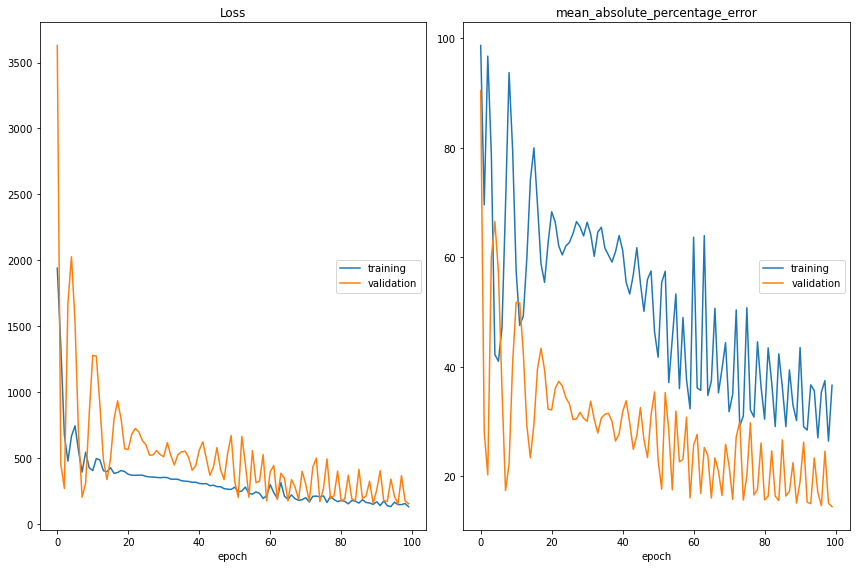

Loss
	training         	 (min:  129.146, max: 1939.722, cur:  129.146)
	validation       	 (min:  149.588, max: 3630.189, cur:  152.004)
mean_absolute_percentage_error
	training         	 (min:   26.441, max:   98.687, cur:   36.632)
	validation       	 (min:   14.451, max:   90.450, cur:   14.451)
2/2 [==============================] - 2s 1s/step - loss: 129.1458 - mean_absolute_percentage_error: 36.6319 - val_loss: 152.0039 - val_mean_absolute_percentage_error: 14.4507


In [14]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics='mean_absolute_percentage_error')
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[PlotLossesCallback()])

# Aplicar o modelo às matrizes de treino

In [15]:
print("Evaluate")
train_mat = tf.expand_dims(train_mat, axis=-1)
result = model.predict(train_mat)
print(result)

Evaluate
[[24.077377]
 [25.8523  ]
 [34.384724]
 [25.152826]
 [27.709366]
 [44.28649 ]
 [36.76373 ]
 [25.89383 ]
 [31.703789]
 [30.475681]
 [35.709496]
 [25.03481 ]
 [38.191814]
 [30.147766]
 [21.176003]
 [30.4927  ]
 [24.389713]
 [28.566282]
 [28.435719]
 [29.474716]
 [28.017334]
 [23.202213]
 [26.393312]
 [30.524853]
 [27.678827]
 [25.929642]
 [38.653736]
 [32.48118 ]
 [33.652325]
 [32.173817]
 [27.30075 ]
 [30.79504 ]
 [29.313173]
 [30.29117 ]
 [27.337648]
 [31.817686]
 [34.416294]
 [27.49126 ]
 [33.779415]
 [26.940285]
 [33.54339 ]
 [28.648602]
 [36.599392]
 [32.08179 ]
 [29.508858]
 [26.309587]
 [31.461529]
 [28.524342]
 [27.417053]
 [20.071806]
 [24.042118]
 [28.300365]
 [34.836197]
 [28.107906]
 [32.5653  ]
 [73.43535 ]
 [52.859806]
 [70.57983 ]
 [46.94856 ]
 [66.62711 ]
 [53.192142]
 [65.24936 ]
 [67.54093 ]
 [72.443146]
 [56.99225 ]
 [73.22188 ]
 [74.72714 ]
 [56.15328 ]
 [59.315937]
 [84.87713 ]
 [61.72282 ]
 [59.57414 ]
 [73.692566]
 [77.93771 ]
 [54.00295 ]
 [48.45017 ]
 [6

In [16]:
valores = []
for x in result:
    for y in x:
        valores.append(y)

In [17]:
train_data['Valores CNN'] = valores

In [11]:
train_data['Valores CNN'] = valores

# Treinar o modelo 2 - com os dados todos do csv mais os resultados do primeiro treino

# Treinar o modelo 2 - com os dados todos do csv mais os resultados do primeiro treino

In [20]:
train_data.shape

(112, 5)

In [21]:
train_data.describe()

,id,age,sex,education,Valores CNN
count,112.000000,112.000000,112.000000,112.000000,112.000000
mean,56.500000,44.312500,0.482143,2.732143,46.724739
std,32.475632,22.642156,0.501927,1.348888,18.300520
min,1.000000,13.000000,0.000000,0.000000,20.071806
25%,28.750000,20.000000,0.000000,2.000000,29.434330
50%,56.500000,51.500000,0.000000,3.000000,45.819145
75%,84.250000,65.250000,1.000000,4.000000,62.713944
max,112.000000,79.000000,1.000000,4.000000,84.877129


In [22]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
train_data[['Valores CNN']] = min_max_scaler.fit_transform(train_data[['Valores CNN']])

In [23]:
train_data.describe()

,id,age,sex,education,Valores CNN
count,112.000000,112.000000,112.000000,112.000000,112.000000
mean,56.500000,44.312500,0.482143,2.732143,0.411277
std,32.475632,22.642156,0.501927,1.348888,0.282392
min,1.000000,13.000000,0.000000,0.000000,0.000000
25%,28.750000,20.000000,0.000000,2.000000,0.144472
50%,56.500000,51.500000,0.000000,3.000000,0.397303
75%,84.250000,65.250000,1.000000,4.000000,0.658004
max,112.000000,79.000000,1.000000,4.000000,1.000000


In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           112 non-null    int64  
 1   age          112 non-null    int64  
 2   sex          112 non-null    int64  
 3   education    112 non-null    int8   
 4   Valores CNN  112 non-null    float32
dtypes: float32(1), int64(3), int8(1)
memory usage: 3.3 KB


In [19]:
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=(4,)))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='relu'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                320       
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 33,473
Trainable params: 33,473
Non-trainable params: 0
_________________________________________________________________


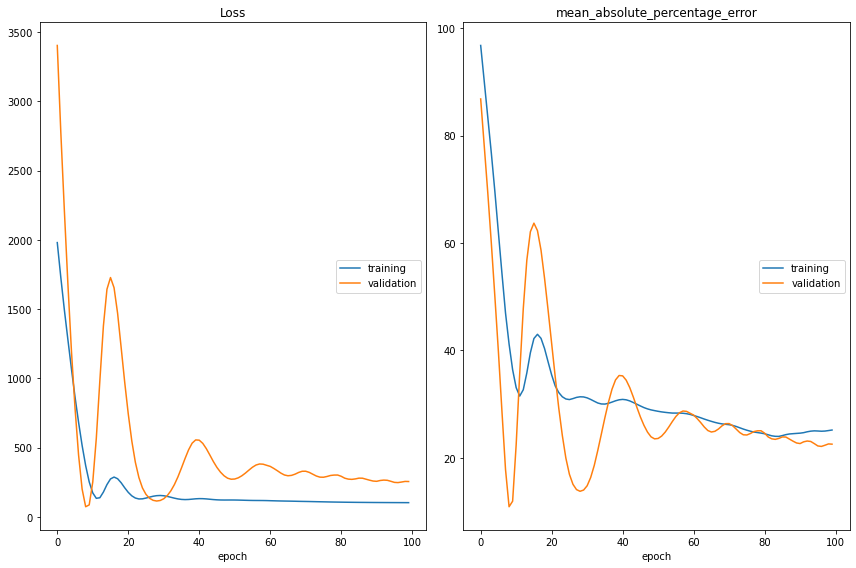

Loss
	training         	 (min:  103.228, max: 1980.099, cur:  103.228)
	validation       	 (min:   73.772, max: 3402.758, cur:  255.746)
mean_absolute_percentage_error
	training         	 (min:   23.978, max:   96.768, cur:   25.163)
	validation       	 (min:   10.881, max:   86.808, cur:   22.533)
1/1 [==============================] - 0s 336ms/step - loss: 103.2278 - mean_absolute_percentage_error: 25.1629 - val_loss: 255.7464 - val_mean_absolute_percentage_error: 22.5326


In [24]:
model2.compile(optimizer='adam', loss='mean_squared_error', metrics='mean_absolute_percentage_error')

x_train = train_data.drop(['age'], axis=1)
y_train = train_data['age']

history2 = model2.fit(x_train, y_train, epochs=100, batch_size=256,validation_split=0.15, callbacks=[PlotLossesCallback()])

# Resultados com model e o modelo2

In [25]:
print("Evaluate Teste com o model (CNN)")
teste_mat = tf.expand_dims(test_mat, axis=-1)
result = model.predict(teste_mat)

valores = []
for x in result:
    for y in x:
        valores.append(y)
        
test_data['Valores CNN'] = valores

result = model2.predict(test_data)
print(result)

Evaluate Teste com o model (CNN)
[[ 58.27995 ]
 [ 66.62733 ]
 [ 59.77291 ]
 [ 55.50128 ]
 [ 54.10523 ]
 [ 53.839634]
 [132.5967  ]
 [ 96.740456]
 [111.22543 ]
 [112.3863  ]
 [117.449745]
 [122.2254  ]
 [129.3531  ]
 [101.38414 ]
 [ 56.91865 ]
 [ 76.6437  ]
 [ 55.015667]
 [ 73.34239 ]
 [ 66.089294]
 [ 63.191517]
 [130.93274 ]
 [ 92.33062 ]
 [114.83259 ]
 [140.66414 ]
 [116.1852  ]
 [113.510345]
 [106.90061 ]
 [ 93.4655  ]]


# Prepare submission

In [26]:
import math
with open("submissaoCarlos.csv", "w") as sub:
    # Writing data to a file
    sub.write('id,age\n')
    for i in test_data['id']:
        sub.write(str(i)+','+str(result[i-1][0])+'\n')
    